In [65]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

/tmp/ipykernel_68131/3777615979.py:1: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [66]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.optim.lr_scheduler import ExponentialLR
import pandas as pd

import numpy as np
import matplotlib.pyplot as plt
import scipy.io as io

import os
import time

## 超参数设置

In [67]:
domain = (-1, 1, -1, 1)
xmin, xmax, ymin, ymax = domain
mlp_layers = [1] + [40]*4 + [1]
mlp_layers_k = [1] + [20]*2 + [1]
n_iters = 200000
# n_iters = 50000
learning_rate = 1e-3
gamma = 0.6

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_path = r'./model'
train_info_path = r'./'
if not os.path.exists(model_path):
    os.mkdir(model_path)

## 数据集生成

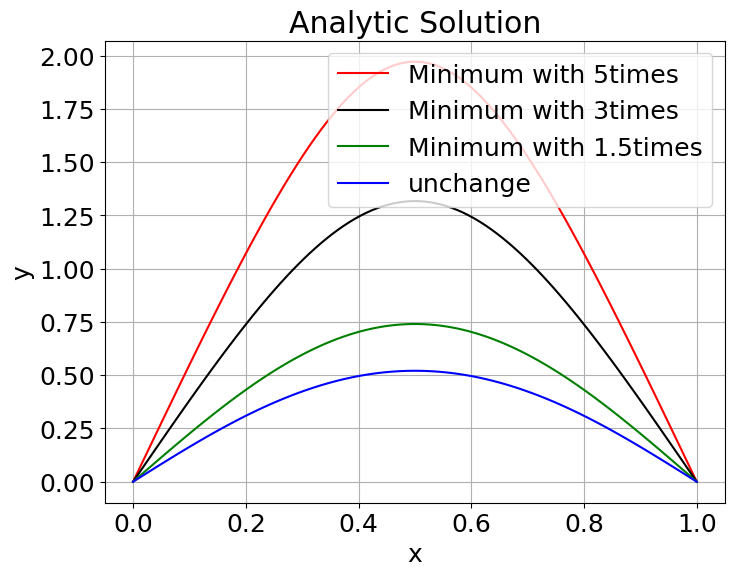

In [68]:
import torch
import matplotlib.pyplot as plt
import pandas as pd
import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

# 生成x的数据点
x = torch.linspace(0, 1, 100)

# 计算对应的y值
#计算解析解，光滑刚度最小值为18750KN.m
y1 = (125*torch.arctan(torch.tensor(2)))/32 - (25*x)/8 - 125*torch.log(torch.tensor(5/16))/128 + (125*torch.log(x**2 - x + 5/16))/128 + (
    125*torch.arctan(4*x - 2))/32 + x*((25*x)/4 - (125*torch.arctan(4*x - 2))/16) - (25*x**2)/8

#计算解析解，光滑刚度最小值为31250KN.m
y2 = (45 * torch.log(x ** 2 - x + 3 / 8)) / 32 - (45 * torch.log(torch.tensor(3/8))) / 32 - (15 * x) / 4 + (
    45 * 2 ** (1 / 2) * torch.arctan(2 * 2 ** (1 / 2) * x - 2 ** (1 / 2))) / 16 + (
    45 * 2 ** (1 / 2) * torch.arctan(torch.tensor(2 ** (1 / 2)))) / 16 + x * (
    (15 * x) / 2 - (45 * 2 ** (1 / 2) * torch.arctan(2 * 2 ** (1 / 2) * x - 2 ** (1 / 2))) / 8) - (
    15 * x ** 2) / 4

#计算解析解，光滑刚度最小值为62500KN.m
y3 = (45*torch.log(x**2 - x + 3/4))/8 - (45*torch.log(torch.tensor(3/4)))/8 - (15*x)/2 + (
    45*2**(1/2)*torch.arctan(2**(1/2)*x - 2**(1/2)/2))/8 + x*(15*x - (45*2**(1/2)*torch.arctan(2**(1/2)*x - 2**(1/2)/2))/4) - (
    15*x**2)/2 + (45*2**(1/2)*torch.arctan(torch.tensor(2**(1/2)/2)))/8

#计算解析解,刚度不变一直为93750KN.m
y4 = 5/3*x**4-10/3*x**3+5/3*x

# 创建一个数据框
data = pd.DataFrame({'x': x.numpy(), 'y1': y1.numpy()})

# 绘制图形
plt.figure(figsize=(8, 6))
plt.plot(x.numpy(), y1.numpy(), 'r-', label='Minimum with 5times')
plt.plot(x.numpy(), y2.numpy(), 'k-', label='Minimum with 3times')
plt.plot(x.numpy(), y3.numpy(), 'g-', label='Minimum with 1.5times')
plt.plot(x.numpy(), y4.numpy(), 'b-', label='unchange')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Analytic Solution')
plt.legend()
plt.grid(True)

# 保存数据到Excel文件
data.to_excel('output.xlsx', index=False)

# 显示图形
plt.show()


In [69]:
class Dataset:
    def __init__(self, N):
        self.x = torch.linspace(0, 1, N)
        
    
    def train_data(self, N, verbose=None):
        # 无量纲化
        t0 = 5
        K0 = 31250
        U0 = 0.001

        x = self.x
        k = self.k(x)
        y = (45*torch.log(x**2 - x + 3/4))/8 - (45*torch.log(torch.tensor(3/4)))/8 - (15*x)/2 + (
            45*2**(1/2)*torch.arctan(2**(1/2)*x - 2**(1/2)/2))/8 + x*(15*x - (45*2**(1/2)*torch.arctan(2**(1/2)*x - 2**(1/2)/2))/4) - (
            15*x**2)/2 + (45*2**(1/2)*torch.arctan(torch.tensor(2**(1/2)/2)))/8

        # y = 5/3*x**4 - 10/3*x**3 + 5/3*x
        # print(self.x.shape)
        idx = np.random.randint(0,self.x.shape[0],N)
        # return x.reshape(-1,1), k.reshape(-1,1), y.reshape(-1,1)
        return x[idx].reshape(-1, 1), k[idx].reshape(-1,1), y[idx].reshape(-1,1)

    # k函数
    def k(self, t):
        return 4/3*t**2 - 4/3*t + 1
        # return np.ones_like(t)
        # return 10000*(t*5-2.5)**2 + 31250
    

N = 1000
dataset = Dataset(N)
t_data, k_data, u_data = dataset.train_data(N)
print(t_data.shape, k_data.shape, u_data.shape)

torch.Size([1000, 1]) torch.Size([1000, 1]) torch.Size([1000, 1])


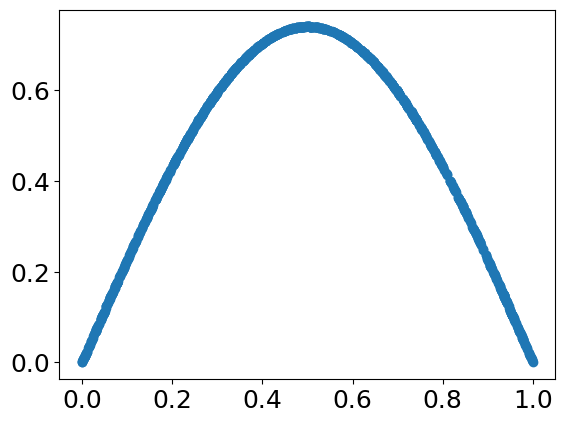

In [70]:
# u_data
plt.scatter(t_data, u_data)

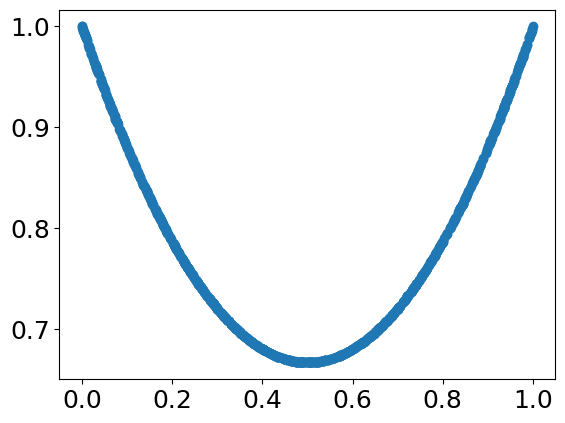

In [71]:
# k_data
plt.scatter(t_data, k_data)

## PINN主干网络

In [72]:
class MLP(nn.Module):
    def __init__(self, mlp_layers):
        super(MLP, self).__init__()
        self.model = nn.Sequential()
        for i in range(len(mlp_layers)-2):
            self.model.add_module(f'fc{i+1}', nn.Linear(mlp_layers[i], mlp_layers[i+1], bias=True))
            self.model.add_module(f'act{i+1}', nn.Tanh())
        self.model.add_module(f'fc{len(mlp_layers)-1})', nn.Linear(mlp_layers[-2], mlp_layers[-1], bias=False))
    
    def forward(self, X):
        return self.model(X)
    
    
mlp = MLP(mlp_layers)
mlp_k = MLP(mlp_layers_k)
mlp.model

Sequential(
  (fc1): Linear(in_features=1, out_features=40, bias=True)
  (act1): Tanh()
  (fc2): Linear(in_features=40, out_features=40, bias=True)
  (act2): Tanh()
  (fc3): Linear(in_features=40, out_features=40, bias=True)
  (act3): Tanh()
  (fc4): Linear(in_features=40, out_features=40, bias=True)
  (act4): Tanh()
  (fc5)): Linear(in_features=40, out_features=1, bias=False)
)

## PINN模型

In [73]:
def grad(outputs, inputs):
    return torch.autograd.grad(outputs, inputs,
                               grad_outputs=torch.ones_like(outputs),
                               create_graph=True)

In [74]:
class PINNHelmholtz(nn.Module):
    def __init__(self, backbone, nn_k):
        super(PINNHelmholtz, self).__init__()
        self.backbone = backbone
        self.nn_k = nn_k
        
    def forward(self, X_res, u_data):
        f_res_pred = self.net_f(X_res)
        u_pred = self.net_u(X_res)

        loss_res_u = torch.mean((f_res_pred - 30) ** 2)
        loss_data_u = torch.mean((u_pred - u_data) ** 2)
        return loss_res_u, loss_data_u
    
    def net_u(self, X):
        return self.backbone(X)
    
    def net_k(self, X):
        # return 8/3*X**2 - 8/3*X + 1
        return self.nn_k(X)

    def net_3u(self, X):
        X.requires_grad_(True)
        u = self.net_u(X)

        # 求u的梯度
        du = grad(u, X)[0]
        d2u = grad(du, X)[0]
        d3u = grad(d2u, X)[0]
        return d3u
    
    def net_f(self, X):
        X.requires_grad_(True)
        u_pred = self.net_u(X)
        
        # 求u的梯度
        du = grad(u_pred, X)[0]
        d2u = grad(du, X)[0]
        d3u = grad(d2u, X)[0]
        d4u = grad(d3u, X)[0]
        
        k_pred = self.net_k(X)
        dk = grad(k_pred, X)[0]
        d2k = grad(dk, X)[0]
        
        f_res_pred = 0.75*k_pred*d4u + 1.5*dk*d3u + 0.75*d2k*d2u
        
        return f_res_pred
    

pinn = PINNHelmholtz(mlp,mlp_k)

## Adam训练

In [75]:
# backbone = MLP(mlp_layers)
# nn_k = MLP(mlp_layers_k)
# pinn = PINNHelmholtz(backbone, nn_k)
# pinn = pinn.to(device)
# model_state = torch.load(os.path.join(model_path, 'backbone_adam_k=1.pth'))
# pinn.backbone.load_state_dict(model_state['backbone_state'])
# pinn.nn_k.load_state_dict(model_state['nn_k_state'])


In [76]:
# 训练
N = 1000
dataset = Dataset(N)
t_data, k_data, u_data = dataset.train_data(N)
t_data = t_data.float().to(device)
u_data = u_data.float().to(device)

backbone = MLP(mlp_layers)
nn_k = MLP(mlp_layers_k)
pinn = PINNHelmholtz(backbone, nn_k)
pinn = pinn.to(device)

optimizer_adam = optim.Adam(pinn.backbone.parameters(), lr=learning_rate)
optimizer_adam_k = optim.Adam(pinn.nn_k.parameters(), lr=learning_rate)

lr_sche = ReduceLROnPlateau(optimizer_adam, mode='min', factor=gamma, verbose=True)
lr_sche_k = ReduceLROnPlateau(optimizer_adam_k, mode='min', factor=gamma, verbose=True)
# lr_sche = ExponentialLR(optimizer_adam, gamma=gamma, verbose=True)
# lr_sche_k = ExponentialLR(optimizer_adam_k, gamma=gamma, verbose=True)

logger = {
    "loss": [],
    "loss_res_u": [],
    "loss_data_u": [],
    "iter": []
}
with open(train_info_path + 'train_info.txt', 'w') as f:
    f.write('Training by Adam:\n')
start_time = time.time()

for it in range(n_iters):
    pinn.zero_grad()
    loss_res_u, loss_data_u = pinn(t_data, u_data)
    # loss = 1*(loss_res_u) + 1e2*(loss_data_u)
    loss = 1*(loss_res_u) + 1e4*(loss_data_u)
    loss.backward()
    optimizer_adam.step()
    optimizer_adam_k.step()
    
    # 保存训练信息 -------
    logger["loss"].append(loss.item())
    logger["loss_res_u"].append(loss_res_u.item())
    logger["loss_data_u"].append(loss_data_u.item())
    logger["iter"].append(it + 1)
    
    if (it + 1) % 100 == 0:  # 打印训练信息 -------
        info = f'Iter # {it+1:4d}/{n_iters}\ttime:{time.time()-start_time:.1f}\t' + f'loss:{loss.item():.2e}, loss_r_u:{loss_res_u.item():.2e}, loss_d_u:{loss_data_u.item():.2e}'
        with open(train_info_path + 'train_info.txt', 'a') as f:
            f.write(info + '\n')
        print(info)
        
    if (it + 1) % 100 == 0:  # 学习率衰减 -------
        lr_sche.step(loss)
        lr_sche_k.step(loss)

Iter #  100/200000	time:1.1	loss:4.44e+02, loss_r_u:9.28e+01, loss_d_u:3.52e-02
Iter #  200/200000	time:2.1	loss:1.73e+02, loss_r_u:3.68e+00, loss_d_u:1.69e-02
Iter #  300/200000	time:3.2	loss:2.00e+00, loss_r_u:3.11e-01, loss_d_u:1.69e-04
Iter #  400/200000	time:4.2	loss:7.33e-01, loss_r_u:1.44e-01, loss_d_u:5.89e-05
Iter #  500/200000	time:5.3	loss:6.92e-01, loss_r_u:1.34e-01, loss_d_u:5.58e-05
Iter #  600/200000	time:6.4	loss:6.71e-01, loss_r_u:1.27e-01, loss_d_u:5.44e-05
Iter #  700/200000	time:7.4	loss:1.04e+01, loss_r_u:1.16e+00, loss_d_u:9.23e-04
Iter #  800/200000	time:8.5	loss:6.53e-01, loss_r_u:1.24e-01, loss_d_u:5.29e-05
Iter #  900/200000	time:9.6	loss:6.47e-01, loss_r_u:1.18e-01, loss_d_u:5.28e-05
Iter # 1000/200000	time:10.7	loss:1.29e+00, loss_r_u:2.03e-01, loss_d_u:1.09e-04
Iter # 1100/200000	time:11.7	loss:6.35e-01, loss_r_u:1.18e-01, loss_d_u:5.18e-05
Iter # 1200/200000	time:12.8	loss:6.29e-01, loss_r_u:1.12e-01, loss_d_u:5.17e-05
Iter # 1300/200000	time:13.9	loss:1.1

In [77]:
model_state = {'iter': it+1, 'backbone_state': pinn.backbone.state_dict(),'nn_k_state': pinn.nn_k.state_dict()}
backbone_path = os.path.join(model_path, f'backbone_adam.pth')
torch.save(model_state, backbone_path)

np.save("./loss_logger_dict.npy", logger)

In [78]:
def used_time(start_time):
    seconds = time.time() - start_time
    minutes, seconds = divmod(seconds, 60)
    hours, minutes = divmod(minutes, 60)
    print(f'used time: {hours:.0f}h {minutes:.0f}m {seconds:.0f}s')
    
used_time(start_time)

used time: 0h 49m 12s


## 结果可视化

In [79]:
plt.rcParams.update({'font.size':18})

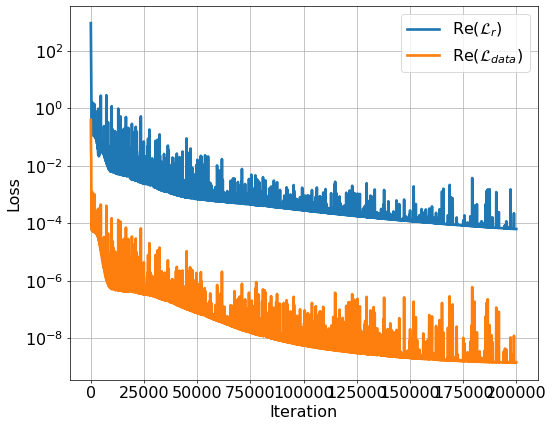

In [80]:
# loss曲线
loss_logger = np.load("./loss_logger_dict.npy", allow_pickle=True).item()

fig = plt.figure(figsize=(9, 7), dpi=64)
ax = fig.subplots()

k = 100
# ax.plot(loss_logger["iter"][::k], loss_logger["loss"][::k], label=r"$\mathcal{L}$", linewidth=3)
ax.plot(loss_logger["iter"][::k], loss_logger["loss_res_u"]
        [::k], label=r"Re($\mathcal{L}_{r})$", linewidth=3)
ax.plot(loss_logger["iter"][::k], loss_logger["loss_data_u"]
        [::k], label=r"Re($\mathcal{L}_{data})$", linewidth=3)
ax.set_yscale('log')
ax.set_xlabel("Iteration")
ax.set_ylabel("Loss")
ax.grid()

ax.legend(loc='upper right')

plt.tight_layout()
plt.savefig('Loss.png', dpi=100, bbox_inches='tight')
plt.show()


In [81]:
backbone = MLP(mlp_layers)
nn_k = MLP(mlp_layers_k)
pinn = PINNHelmholtz(backbone, nn_k)
pinn = pinn.to(device)
model_state = torch.load(os.path.join(model_path, 'backbone_adam.pth'))
pinn.backbone.load_state_dict(model_state['backbone_state'])
pinn.nn_k.load_state_dict(model_state['nn_k_state'])


<All keys matched successfully>

In [82]:
N = 2000
dataset = Dataset(N)
t_data, k_data, u_data = dataset.train_data(N)

In [83]:
# relative L2 误差
u_data = np.array(u_data).reshape(-1, 1)
t_data = np.array(t_data).reshape(-1, 1)
k_data = np.array(k_data).reshape(-1, 1)

t_data = torch.tensor(t_data).float().to(device)
u_pred = pinn.net_u(t_data).detach().cpu().numpy()
k_pred = pinn.net_k(t_data).detach().cpu().numpy()
u3_pred = pinn.net_3u(t_data).detach().cpu().numpy()

t_data = t_data.detach().cpu().numpy()
error_u = np.linalg.norm(u_pred - u_data) / np.linalg.norm(u_data)
error_k = np.linalg.norm(k_pred - k_data) / np.linalg.norm(k_data)
print('u Relative l2 error: {:.3e}'.format(error_u))
print('k Relative l2 error: {:.3e}'.format(error_k))


u Relative l2 error: 7.181e-05
k Relative l2 error: 1.607e-02


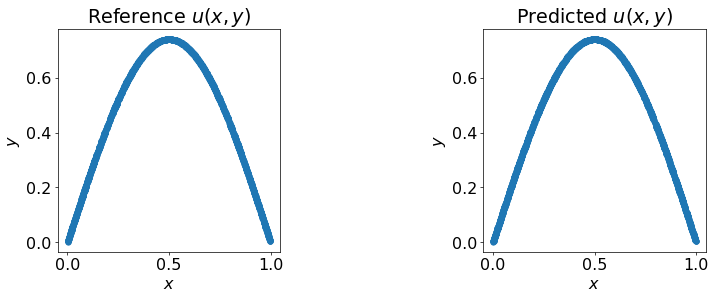

In [84]:
fig = plt.figure(figsize=(14, 5), dpi=64)
[ax, ax2] = fig.subplots(1, 2)

# cax = ax.plot(t_data, u_data)
# cax = ax.plot(t_data, u_pred)

cax = ax.scatter(t_data, u_data)
# cax = ax.scatter(t_data, u_pred)
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
ax.set_title(r'Reference $u(x,y)$')
ax.set_aspect(1./ax.get_data_ratio())

# cax2 = ax2.plot(t_data, np.abs(u_data - u_pred))
cax2 = ax2.scatter(t_data, u_pred)
ax2.set_xlabel('$x$')
ax2.set_ylabel('$y$')
ax2.set_title(r'Predicted $u(x,y)$')
ax2.set_aspect(1./ax2.get_data_ratio())

plt.tight_layout()
plt.savefig('u.png')
plt.show()


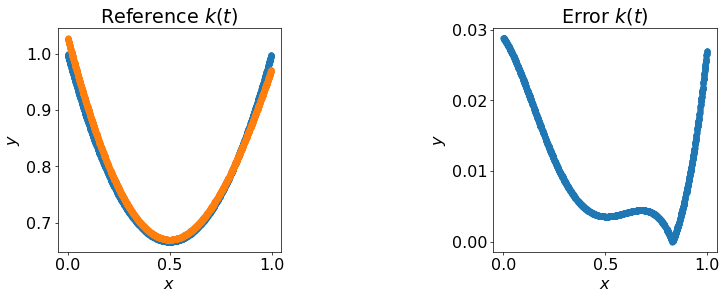

In [85]:
fig = plt.figure(figsize=(14, 5), dpi=64)
[ax, ax2] = fig.subplots(1, 2)

# cax = ax.plot(t_data, k_data)
# cax = ax.plot(t_data, k_pred)

cax = ax.scatter(t_data, k_data)
cax = ax.scatter(t_data, k_pred)
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
ax.set_title(r'Reference $k(t)$')
ax.set_aspect(1./ax.get_data_ratio())

# cax2 = ax2.plot(t_data, np.abs(k_data - k_pred))
cax2 = ax2.scatter(t_data, np.abs(k_data - k_pred))
ax2.set_xlabel('$x$')
ax2.set_ylabel('$y$')
ax2.set_title(r'Error $k(t)$')
ax2.set_aspect(1./ax2.get_data_ratio())

plt.tight_layout()
plt.savefig('K.png')
plt.show()


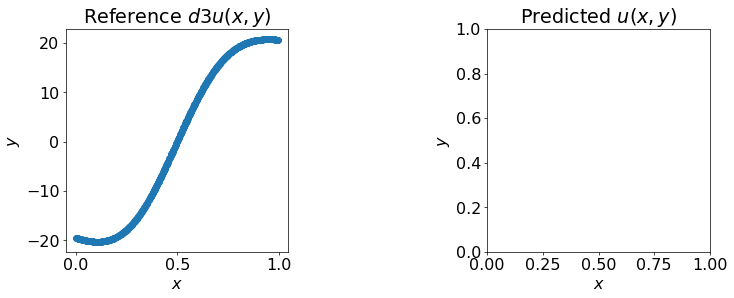

In [86]:
fig = plt.figure(figsize=(14, 5), dpi=64)
[ax, ax2] = fig.subplots(1, 2)

cax = ax.scatter(t_data, u3_pred)
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
ax.set_title(r'Reference $d3u(x,y)$')
ax.set_aspect(1./ax.get_data_ratio())

# cax2 = ax2.plot(t_data, np.abs(u_data - u_pred))
ax2.set_xlabel('$x$')
ax2.set_ylabel('$y$')
ax2.set_title(r'Predicted $u(x,y)$')
ax2.set_aspect(1./ax2.get_data_ratio())

plt.tight_layout()
plt.savefig('u.png')
plt.show()
